IMPORTING THE DEPENDENCIES

In [ ]:
import json
import math as m

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

DEFINING A FUNCTION TO FILTER WORDS IN A HEADLINE AND TO BUILD A VOCABULARY LIST

In [ ]:
def get_filtered_words(headline):
    return [word for word in word_tokenize(headline) if not word in stop_words]
def build_vocab_list(train_dataset):
    vocab_list = []
    for record in train_dataset:
        filtered_words = get_filtered_words(record['headline'])
        vocab_list.extend(filtered_words)
    return vocab_list

DEFINING A FUNCTION TO BUILD A DICTIONARY OF WORD FREQUENCIES FOR EACH CATEGORY

In [ ]:
def build_doc_freq_dict(train_dataset,categories):
    word_frequency_dict = {category:{vocab:0 for vocab in vocab_list} for category in categories}
    for record in train_dataset:
        for word in get_filtered_words(record['headline']):
            word_frequency_dict[record['category']][word]+=1
    return word_frequency_dict


DEFINING A FUNCTION TO GROUP THE DATASET BY CATEGORIES

In [ ]:
def get_data_group_by_classes(dataset):
    seperated_category_dict = {category:[] for category in categories}
    for record in dataset:
        seperated_category_dict[record['category']].append(record)
    return seperated_category_dict

DEFINING A FUNCTION TO CHECK IF SMOOTHING IS NEEDED FOR A GIVEN CATEGORY AND TO CALCULATE THE NAIVE BAYES PROBABILITY FOR A GIVEN CATEGORY AND TEXT

In [ ]:
def is_smoothing_needed(filterd_words,word_dict,category):
    for word in filterd_words:
        if word not in word_dict[category].keys():
            return True
    return False

def get_naive_probability(category,text,word_dict,grouped_classes_dict,dataset):
    if category not in word_dict.keys():
        return
    total_word_cond_prob = 1
    smoothing_factor = 0.001
    filterd_words = get_filtered_words(text)
    smoothing_indicator = is_smoothing_needed(filterd_words,word_dict,category)
    for word in filterd_words:
        if smoothing_indicator :
            word_doc_freq = word_dict[category][word] if word in word_dict[category].keys() else 0
            total_word_cond_prob *= ((word_doc_freq+1)/((len(grouped_classes_dict[category])+(smoothing_factor*len(grouped_classes_dict[category]))))) # Smoothing technique
        else:
            total_word_cond_prob *= (word_dict[category][word]/len(grouped_classes_dict[category]))
    class_probability = (len(grouped_classes_dict[category])/len(dataset))
    return total_word_cond_prob * class_probability


DEFINING A FUNCTION TO PREDICT THE CATEGORY FOR A GIVEN TEXT

In [ ]:
def get_predicted_class(categories,str_to_predict,word_frequency_dict,group_classes_dict,train_dataset):
    greatest_prob = 0
    predicted_category = ''
    for category in categories:
        total_word_cond_prob = 1
        prob_of_category_contains_headline =  get_naive_probability(category,str_to_predict,word_frequency_dict,group_classes_dict,train_dataset)
        if prob_of_category_contains_headline > greatest_prob:
            greatest_prob = prob_of_category_contains_headline
            predicted_category = category
    return predicted_category

DEFINING A FUNCTION TO CALCULATE THE ACCURACY OF THE NAIVE BAYES CLASSIFIER

In [ ]:
def get_accuracy(dataset,categories,word_frequency_dict,group_classes_dict):
    correct_predicted = 0
    for record in dataset:
        predicted_category = get_predicted_class(categories,record['headline'],word_frequency_dict,group_classes_dict,dataset)
        if predicted_category == record['category']:
            correct_predicted+=1
    return correct_predicted/len(dataset)

DEFINING A FUNCTION TO GET THE TOP WORDS FOR A GIVEN CATEGORY

In [ ]:
def get_top_words(word_frequency_dict,category):
    sorted_list = sorted(word_frequency_dict[category].items(), key=lambda item: item[1],reverse=True)
    top_words = {word:count for word, count in sorted_list if len(word)>2}
    return top_words

DEFINING A FUNCTION TO VISUALISE THE TOP WORDS FOR EACH CATEGORY USING WORD CLOUDS

In [ ]:
def print_top_words(word_frequency_dict,categories):
    plt.figure(figsize=(18,30))
    for index,category in enumerate(categories,start=1):
        words = get_top_words(word_frequency_dict,category)
        wordcloud = WordCloud(width = 480, height = 480,background_color ='white',
                        min_font_size = 14)
        wordcloud.generate_from_frequencies(words)
        plt.subplot(8,5,index)
        plt.imshow(wordcloud,interpolation="bilinear")
        plt.title(category)
        plt.axis("off")
    plt.show()

LOADING THE DATASET FROM A JSON FILE AND DISPLAYING THE FIRST FEW ROWS OF THE DATASET

In [ ]:
df = pd.read_json('/content/News_Category_Dataset_v3.json',lines=True)
df.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

DISPLAYING THE UNIQUE CATEGORIES IN THE DATASET

In [ ]:
df.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

PREPROCESSING THE DATASET BY CONVERTING ALL HEADLINES TO LOWERCASE AND REMOVING UNWANTED CATEGORIES

In [ ]:
dataset = []
categories = []
stop_words= set(stopwords.words('english'))
with open('/content/News_Category_Dataset_v3.json') as data:
    for line_num,file_text in enumerate(data,start=0):
        file_text = file_text.replace('"category": "CULTURE & ARTS",','"category": "ARTS & CULTURE",',1).replace('"category": "WORLDPOST",','"category": "THE WORLDPOST",',1).replace('"category": "PARENTING",','"category": "PARENTS",',1)
        record = json.loads(file_text)
        processed_record = {"category":record['category'],"headline":record['headline'].lower()}
        dataset.append(processed_record)
        if dataset[line_num]['category'] not in categories:
            categories.append(dataset[line_num]['category'])
no_of_records = len(dataset)
print(f""" Number of Records in the DataSet: {no_of_records}""")
print(f""" Number of Different Categories in the DataSet: {len(categories)}""")

 Number of Records in the DataSet: 209527
 Number of Different Categories in the DataSet: 39


CONVERTING THE PREPROCESSED DATASET TO A PANDAS DATAFRAME AND DISPLAYING THE FIRST FEW ROWS OF THE DATAFRAME

In [ ]:
df2 = pd.DataFrame(dataset)
df2.head()

category                                           headline
0  U.S. NEWS  over 4 million americans roll up sleeves for o...
1  U.S. NEWS  american airlines flyer charged, banned for li...
2     COMEDY  23 of the funniest tweets about cats and dogs ...
3    PARENTS  the funniest tweets from parents this week (se...
4  U.S. NEWS  woman who called cops on black bird-watcher lo...

VISUALISING THE DISTRIBUTION OF RECORDS ACROSS CATEGORIES USING A BAR CHART

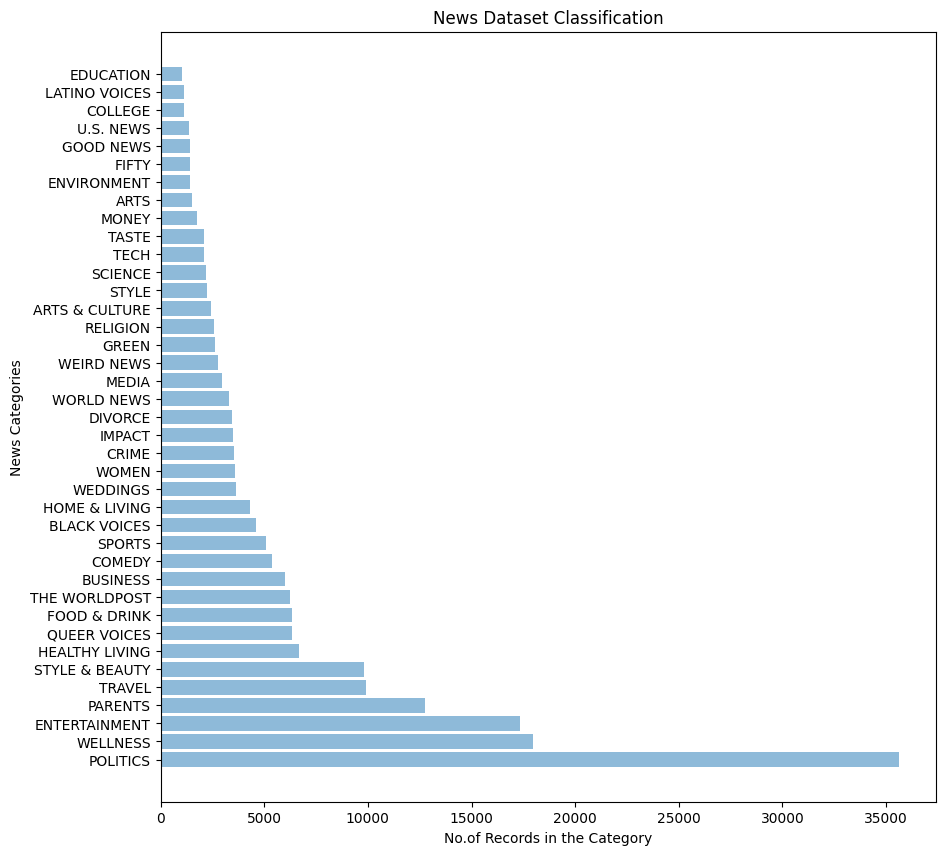

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(df2.loc[:,'category'].value_counts().keys(),df2.loc[:,'category'].value_counts().values, alpha=0.5)
ax.set_ylabel("News Categories")
ax.set_xlabel('No.of Records in the Category')
ax.set_title('News Dataset Classification')
plt.show()

PERFORMING k-FOLD CROSS-VALIDATION

Iteration:1 Accuracy of the Naive Baye's Classifier over Test DataSet is 42.22%
Iteration:2 Accuracy of the Naive Baye's Classifier over Test DataSet is 41.71%
Iteration:3 Accuracy of the Naive Baye's Classifier over Test DataSet is 42.36%
Iteration:4 Accuracy of the Naive Baye's Classifier over Test DataSet is 42.06%
Iteration:5 Accuracy of the Naive Baye's Classifier over Test DataSet is 42.28%


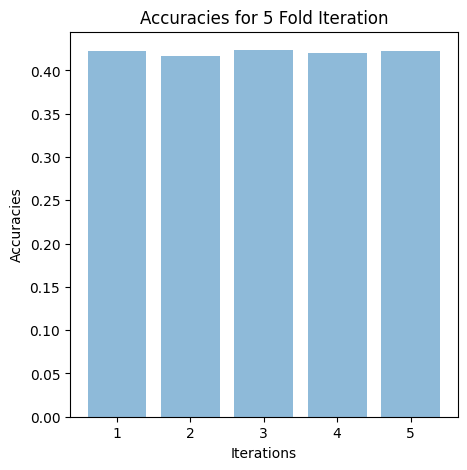

Average Accuracy of the Naive Baye's Classifier over Test DataSet is 42.12%


In [ ]:
k_fold =5
accuracy_list = []
for i in range(k_fold):
    train_dataset,test_dataset = train_test_split(dataset,test_size=0.1)
    group_classes_dict = get_data_group_by_classes(train_dataset)
    vocab_list = build_vocab_list(train_dataset)
    word_frequency_dict = build_doc_freq_dict(train_dataset,categories)
    test_accuracy = get_accuracy(test_dataset,categories,word_frequency_dict,group_classes_dict)
    print(f'''Iteration:{i+1} Accuracy of the Naive Baye's Classifier over Test DataSet is {round(test_accuracy*100,2)}%''')
    accuracy_list.append(test_accuracy)
fig2, ax2 = plt.subplots()
fig2.set_figheight(5)
fig2.set_figwidth(5)
ax2.bar(np.arange(1,6),accuracy_list, alpha=0.5)
ax2.set_ylabel("Accuracies")
ax2.set_xlabel('Iterations')
ax2.set_title('Accuracies for 5 Fold Iteration')
plt.show()
print(f'''Average Accuracy of the Naive Baye's Classifier over Test DataSet is {round(np.mean(np.array(accuracy_list))*100,2)}%''')

VISUALISING THE TOP WORDS FOR EACH CATEGORY USING WORD CLOUDS

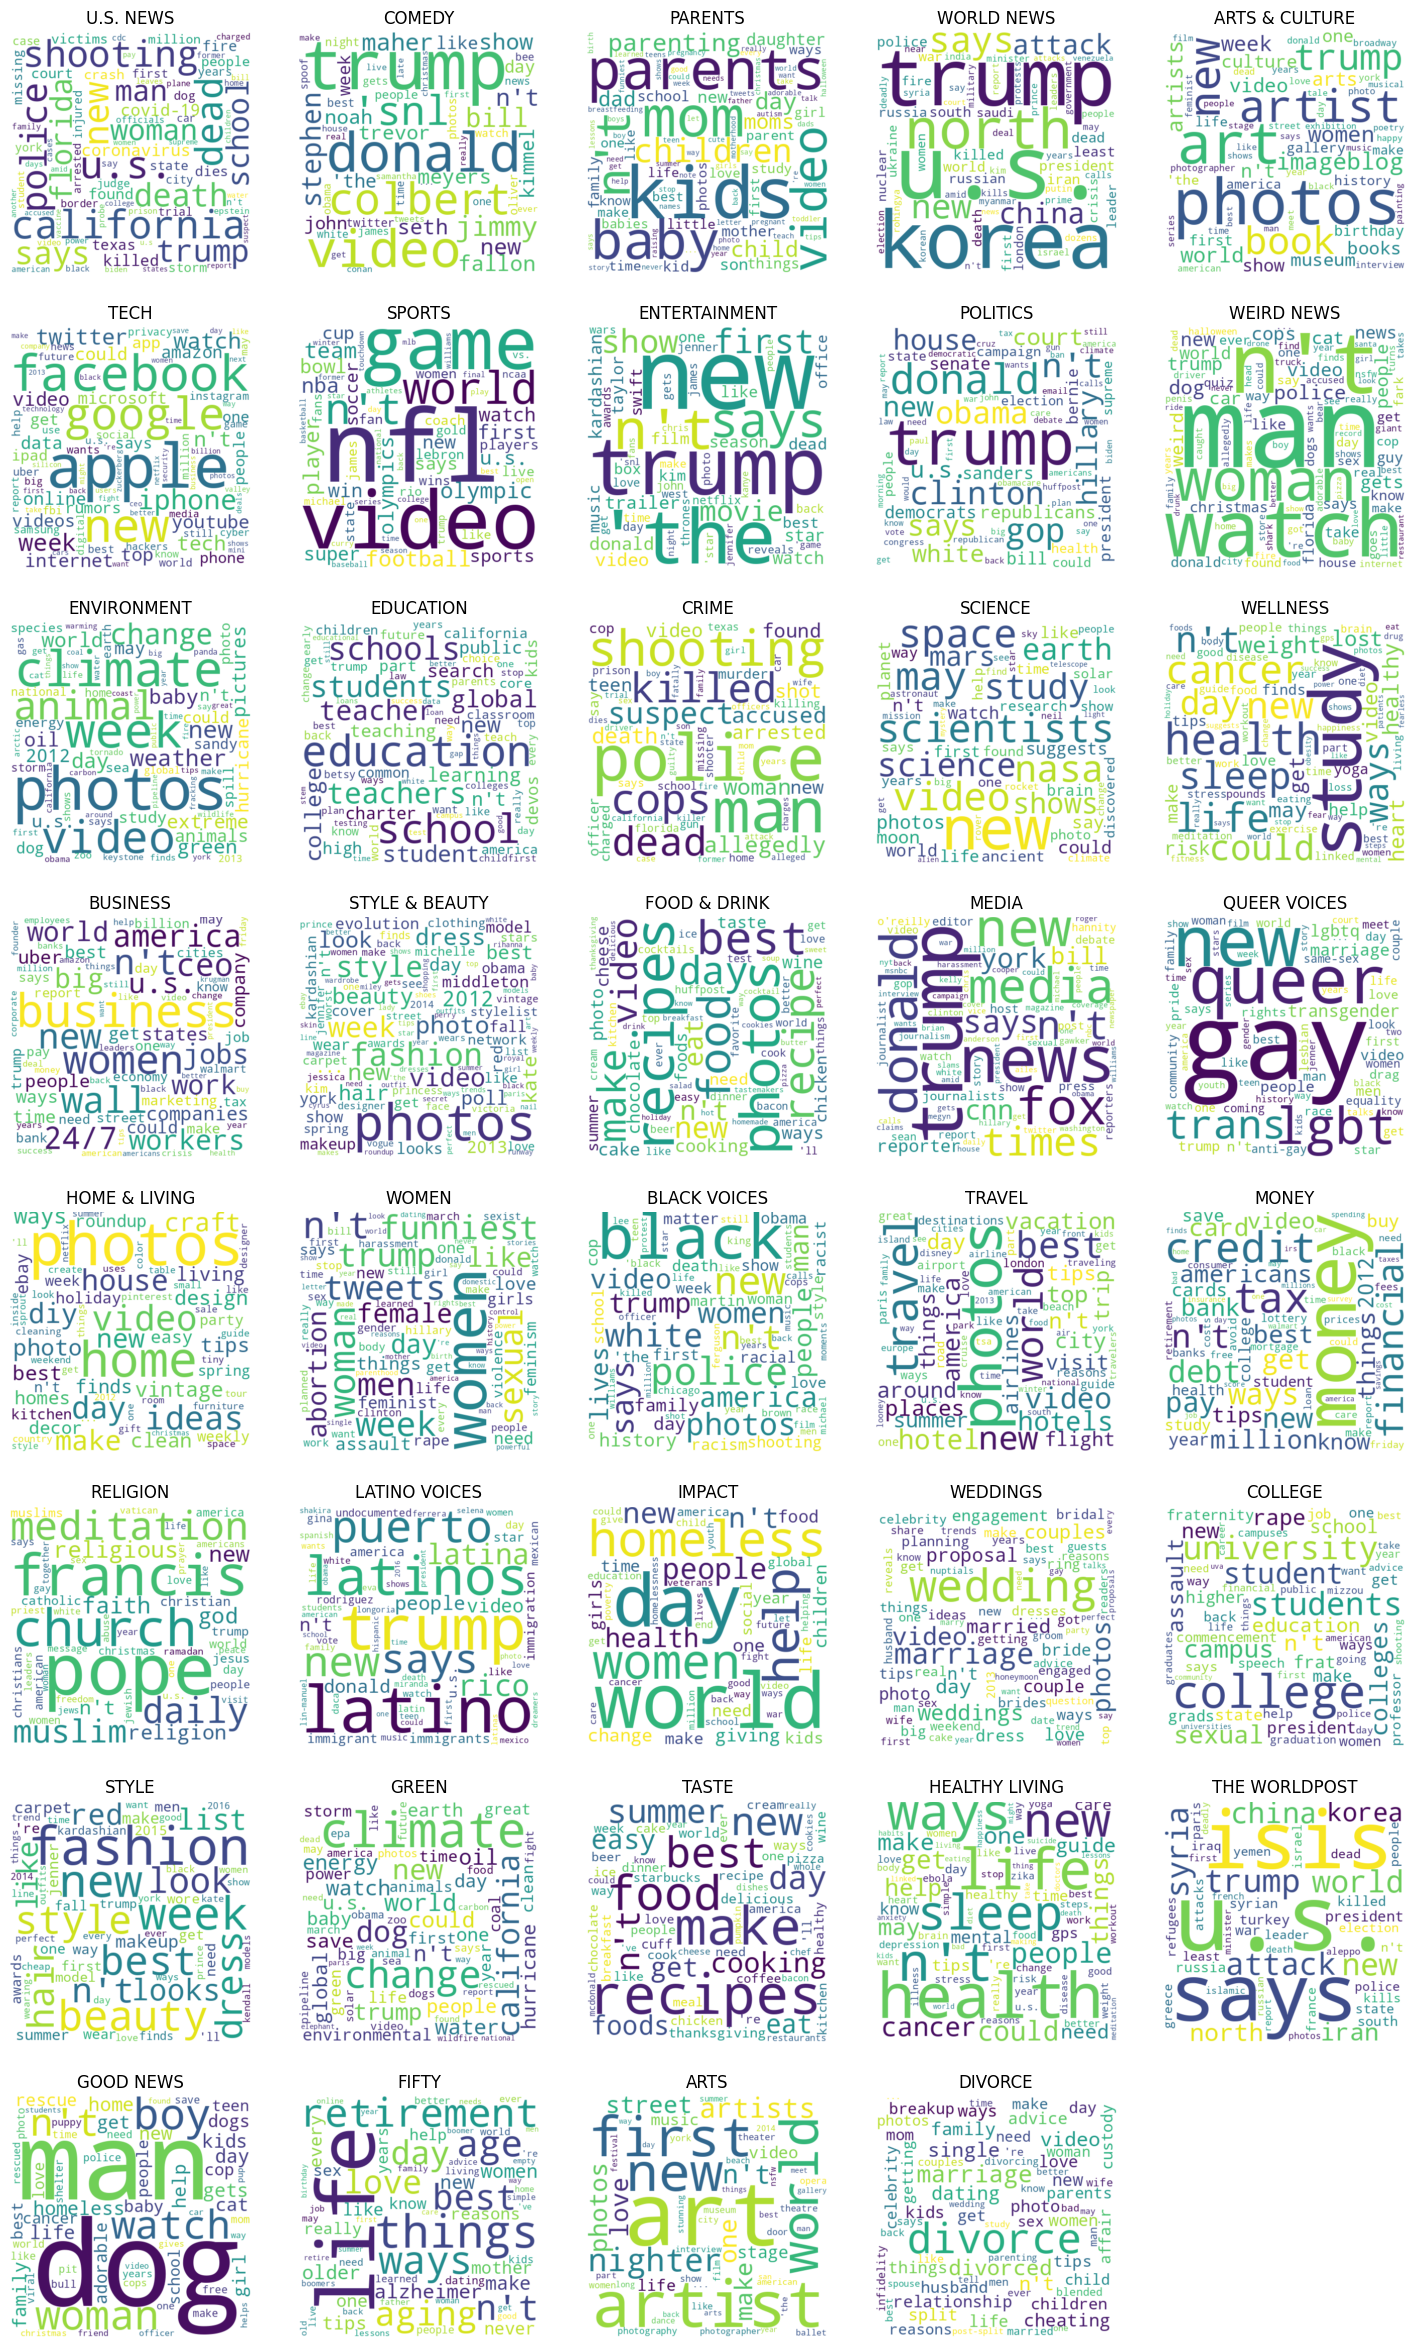

In [ ]:
 print_top_words(word_frequency_dict,categories)